In [12]:
pgh_wlls = pd.read_csv('Primary Data/PGH_WLLS_GEOCODED_1619.csv')

pgh_wlls = gpd.GeoDataFrame(pgh_wlls[['ANALYZED ON',
                                        'LEAD RESULT',
                                        'Address',
                                        'X',
                                        'Y']].rename(columns={'Address':'Block'}), 
                            geometry=[shapely.geometry.Point((pgh_wlls.X[i],pgh_wlls.Y[i])) for i in pgh_wlls.index])
pgh_wlls = ecdf(pgh_wlls[pgh_wlls['LEAD RESULT']<30].rename(columns={'LEAD RESULT':'Pb'}), 'Pb')
pgh_wlls[['ANALYZED ON','Block','Pb','Pb_ecd','geometry']].head()

,ANALYZED ON,Block,Pb,Pb_ecd,geometry
5316,2016-11-03,4100 WINTERBURN AVE,0.0,0.000096,POINT (-79.9393696646642 40.4252317996763)
5946,2016-12-16,6000 WELLESLEY AVE,0.0,0.000192,POINT (-79.91908426331102 40.4726377055376)
5945,2017-01-11,1100 HEBERTON ST,0.0,0.000288,POINT (-79.9146816633627 40.47327816750479)
5944,2016-11-11,900 WELLESLEY RD,0.0,0.000384,POINT (-79.9138808299541 40.4716613267441)
5942,2016-12-29,1200 N SHERIDAN AVE,0.0,0.000480,POINT (-79.9157686520862 40.474511545325)


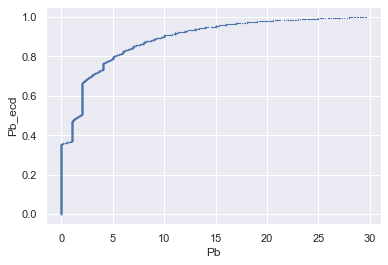

In [15]:
sns.scatterplot(x='Pb', y='Pb_ecd',data=pgh_wlls, s=0.4, marker='x')

In [16]:
pwsa = pd.read_csv('C:/Users/raana/OneDrive/Desktop/Pitt/THESIS/Code/PWSA_data.csv')
pwsa = gpd.GeoDataFrame(pwsa, 
                        geometry=[shapely.geometry.Point((pwsa.x[i],pwsa.y[i])) for i in pwsa.index])

pb = []
for i in pwsa.index:
    
    x = pwsa['PublicSide_PrivateSide'][i].split(" / ")
    
    if len(x) == 2:
        y, z = x
        if y == 'Lead' or z == 'Lead':
            pb.append('Lead')
        elif y == 'Galvanized Iron' or z == 'Galvanized Iron':
            pb.append('Lead')
        elif y == 'Non-Lead' and z == 'Non-Lead':
            pb.append('Non-Lead')
        else:
            pb.append('Unk')
    else:
        pb.append('Unk')
        
pwsa['LSL'] = pb
print('Total observations: '+str(len(pwsa.dropna(subset=['LSL']))))
print(pwsa['LSL'].value_counts())
pwsa[['PublicSide_PrivateSide','LSL','Material_Source','geometry']].head()

Total observations: 47958
Lead        27829
Non-Lead    14171
Unk          5958
Name: LSL, dtype: int64


,PublicSide_PrivateSide,LSL,Material_Source,geometry
0,Non-Lead / Non-Lead,Non-Lead,Historical Record,POINT (-79.98742415 40.44381645)
1,Non-Lead / Lead,Lead,Historical Record,POINT (-79.92347873999999 40.42678981)
2,Non-Lead / Non-Lead,Non-Lead,Historical Record,POINT (-79.95927521 40.43703056)
3,Non-Lead / No Data,Unk,Historical Record,POINT (-79.92704836999999 40.42399145)
4,Non-Lead / Non-Lead,Non-Lead,Historical Record,POINT (-80.03491750000001 40.43091958)


0 Id
1 Id2
2 Geography
3 Estimate; Median year structure built
4 Margin of Error; Median year structure built
5 Estimate; Total:
6 Estimate; Total: - Built 2014 or later
7 Estimate; Total: - Built 2010 to 2013
8 Estimate; Total: - Built 2000 to 2009
9 Estimate; Total: - Built 1990 to 1999
10 Estimate; Total: - Built 1980 to 1989
11 Estimate; Total: - Built 1970 to 1979
12 Estimate; Total: - Built 1960 to 1969
13 Estimate; Total: - Built 1950 to 1959
14 Estimate; Total: - Built 1940 to 1949
15 Estimate; Total: - Built 1939 or earlier
16 Estimate; Total: - Occupied
17 Estimate; Total: - Vacant
18 Perc. Built 2014 or later
19 Perc. Built 2010 to 2013
20 Perc. Built 2000 to 2009
21 Perc. Built 1990 to 1999
22 Perc. Built 1980 to 1989
23 Perc. Built 1970 to 1979
24 Perc. Built 1960 to 1969
25 Perc. Built 1950 to 1959
26 Perc. Built 1940 to 1949
27 Perc. Built 1939 or earlier
28 Perc. Occupied
29 Perc. Vacant
30 WMed_Age


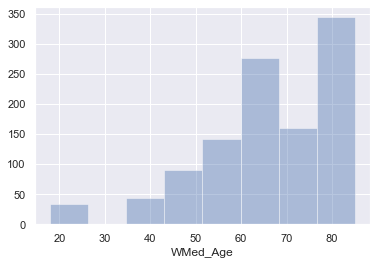

In [33]:
med_yb = pd.read_csv('ACS_17_5YR_B25035_with_ann.csv', header=1)
med_yb['Id2'] = med_yb.Id2.astype(str)
x=[]
for i in med_yb['Estimate; Median year structure built']:
    try:
        x.append(int(i))
    except ValueError:
        x.append(np.nan)
med_yb['Estimate; Median year structure built'] = x

for i in pd.read_csv('ACS_17_5YR_B25034_with_ann.csv', header=1).columns[3:]:
    if 'Estimate' in i:
        med_yb[i] = pd.read_csv('ACS_17_5YR_B25034_with_ann.csv', header=1)[i]

for i in pd.read_csv('ACS_17_5YR_B25002_with_ann.csv', header=1).columns[3:]:
    if 'Estimate' in i and i != 'Estimate; Total:':
        med_yb[i] = pd.read_csv('ACS_17_5YR_B25002_with_ann.csv', header=1)[i]
        
for i in med_yb.columns[6:]:
    col = 'Perc. '+i.split(' - ')[1]
    med_yb[col] = med_yb[i] / med_yb['Estimate; Total:']

med_yb.dropna(subset=['Perc. Built 2014 or later'],inplace=True)
x = [2020 - i for i in [2018,2011,2002,1995,1985,1975,1965,1955,1945,1935]]
med_yb['WMed_Age'] = [weighted_median(x, weights=[med_yb[col][i] for col in med_yb.columns[18:28]]) for i in med_yb.index]

x = 0
for i in med_yb.columns:
    print(str(x) + " " + i)
    x+=1
    
sns.distplot(med_yb['WMed_Age'], kde=False, bins=8)

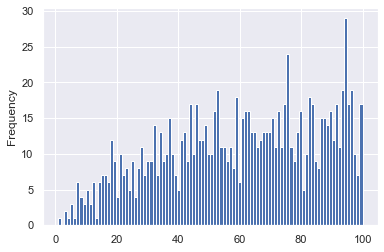

In [30]:
PA_blocks = gpd.read_file("tl_2017_42_bg.shp")
adi = pd.read_csv('Secondary Data/US_blockgroup_15.csv')
county = []
for i in adi.index:
    x = str(adi.fips[i])[0:5]
    county.append(x)
adi['county'] = county
adi = adi[adi.county == '42003'] # Allegheny County
adi['fips'] = adi['fips'].astype(str)
PA_blocks['fips'] = PA_blocks['GEOID'].astype(str)
adi = gpd.GeoDataFrame(pd.merge(adi, PA_blocks[['fips','geometry']], how='left',on='fips'))
nr = []
for i in adi.index:
    if adi.adi_natrank[i] in ['GQ', 'GQ-PH', 'PH']:
        nr.append(np.nan)
    else:
        nr.append(int(adi.adi_natrank[i]))
adi['adi_natrank'] = nr
adi.adi_natrank.plot.hist(bins=100)

In [34]:
adi = pd.merge(adi[['fips','adi_natrank']], PA_blocks, on='fips',how='inner')
adi_acs = pd.merge(adi, med_yb.rename(columns={'Id2':'fips'}), on='fips', how='inner')

# Assign a FIPS block group ID to each observation via spatial join
pwsa = sjoin(pwsa, gpd.GeoDataFrame(adi_acs[['fips','geometry']]),how='inner',op='intersects')
pgh_wlls = sjoin(pgh_wlls.dropna(subset=['X']), gpd.GeoDataFrame(adi_acs[['fips','geometry']]),how='inner',op='intersects')

nPb, meanPb, medianPb, stdPb, madPb = [],[],[],[],[]
nSL, nLSL, nNLSL, pct1 = [], [], [], []
fails = []
x = 0
f = 0
for i in adi_acs.fips:
    print('Progress: {:.2%}   Fails {}'.format(x/len(adi_acs),f), end='\r')
    x += 1
    
    
    try:
        block_props = pgh_wlls[pgh_wlls.fips==i]
        if 'Pb_ecd' in block_props.columns:
            stats  = block_props['Pb_ecd'].describe()
            nPb.append(stats[0])
            meanPb.append(stats[1])
            medianPb.append(stats[4])
            stdPb.append(stats[2])
            madPb.append(block_props['Pb_ecd'].mad())

    except:
        #print('Fail at {}: pgh_wlls'.format(x))
        nPb.append(np.nan)
        meanPb.append(np.nan)
        medianPb.append(np.nan)
        stdPb.append(np.nan)
        madPb.append(np.nan)
        f+=1
        
    try:
        block_props = pwsa[pwsa.fips==i]
        if 'LSL' in block_props.columns:
            nSL.append(len(block_props[block_props.LSL.isin(['Lead','Non-Lead'])]))
            nLSL.append(len(block_props[block_props.LSL=='Lead']))
            nNLSL.append(len(block_props[block_props.LSL=='Non-Lead']))
            if len(block_props[block_props.LSL.isin(['Lead','Non-Lead'])]) > 0:
                pct1.append(len(block_props[block_props.LSL=='Lead'])/len(block_props[block_props.LSL.isin(['Lead','Non-Lead'])]))
            else:
                pct1.append(np.nan)
        
    except:
        #print('Fail at {}: pwsa'.format(x))
        nSL.append(np.nan)
        nLSL.append(np.nan)
        nNLSL.append(np.nan)
        pct1.append(np.nan)
        if f != y:
            f+=1
df = pd.DataFrame({'fips':[i for i in adi_acs.fips],
                   'nPb':nPb, 'meanPb':meanPb, 'medianPb':medianPb,' stdPb':stdPb, 'madPb':madPb, 
                   'nSL':nSL, 'nLSL':nLSL, 'nNLSL':nNLSL, 'pct1':pct1})

agg_df = gpd.GeoDataFrame(pd.merge(df, adi_acs[['fips',
                                                'adi_natrank',
                                                'Estimate; Total:',
                                                'WMed_Age', 
                                                'Perc. Vacant', 
                                                'geometry']], 
                                   on='fips', how='left'))
agg_df.head()
psa = gpd.read_file('C:/Users/raana/OneDrive/Desktop/Pitt/THESIS/GIS/pwsa_service_area/pwsa_water_service_area.shp')
agg_df = gpd.overlay(psa, agg_df, how='intersection')

C:\Users\raana\Anaconda3\envs\gis\lib\site-packages\geopandas\base.py:29: UserWarning: GeoSeries crs mismatch: {'init': 'epsg:4326'} and None
  other.crs))


In [63]:
gwr = agg_df[['fips',
        'nPb',
        'medianPb',
        'adi_natrank',
        'pct1',
        'WMed_Age',
        'geometry']].drop_duplicates(subset='fips')

gwr.to_file('Synthetic Data/AGG_PGH_GWR_output4.shp')

agg_df[['fips',
        'nPb',
        'medianPb',
        'adi_natrank',
        'pct1',
        'WMed_Age',
        'geometry']].drop_duplicates(subset='fips').dropna().to_file('Synthetic Data/AGG_PGH_GWR_nonan4.shp')

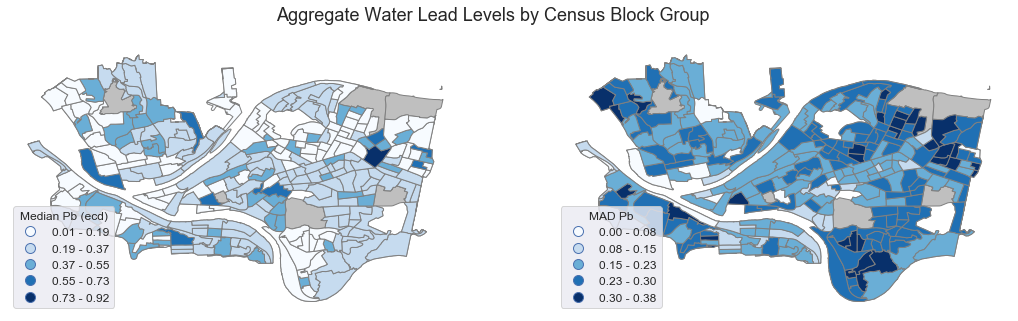

In [64]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))
fig.suptitle('Aggregate Water Lead Levels by Census Block Group', fontsize=18)
for ax in [ax1,ax2]:
    ax = gwr.plot(color='0.75',edgecolor='grey',ax=ax)
    ax.set_axis_off()

agg_df.dropna(subset=['medianPb']).plot(column='medianPb', scheme='equal_interval', cmap='Blues', linewidth=1, edgecolor='grey',legend=True,legend_kwds={'title':'Median Pb (ecd)','loc':'lower left','title_fontsize':12,'fontsize':12}, ax=ax1)
agg_df.dropna(subset=['madPb']).plot(column='madPb', scheme='equal_interval', cmap='Blues', linewidth=1, edgecolor='grey', legend=True, legend_kwds={'title':'MAD Pb','loc':'lower left','title_fontsize':12,'fontsize':12}, ax=ax2)

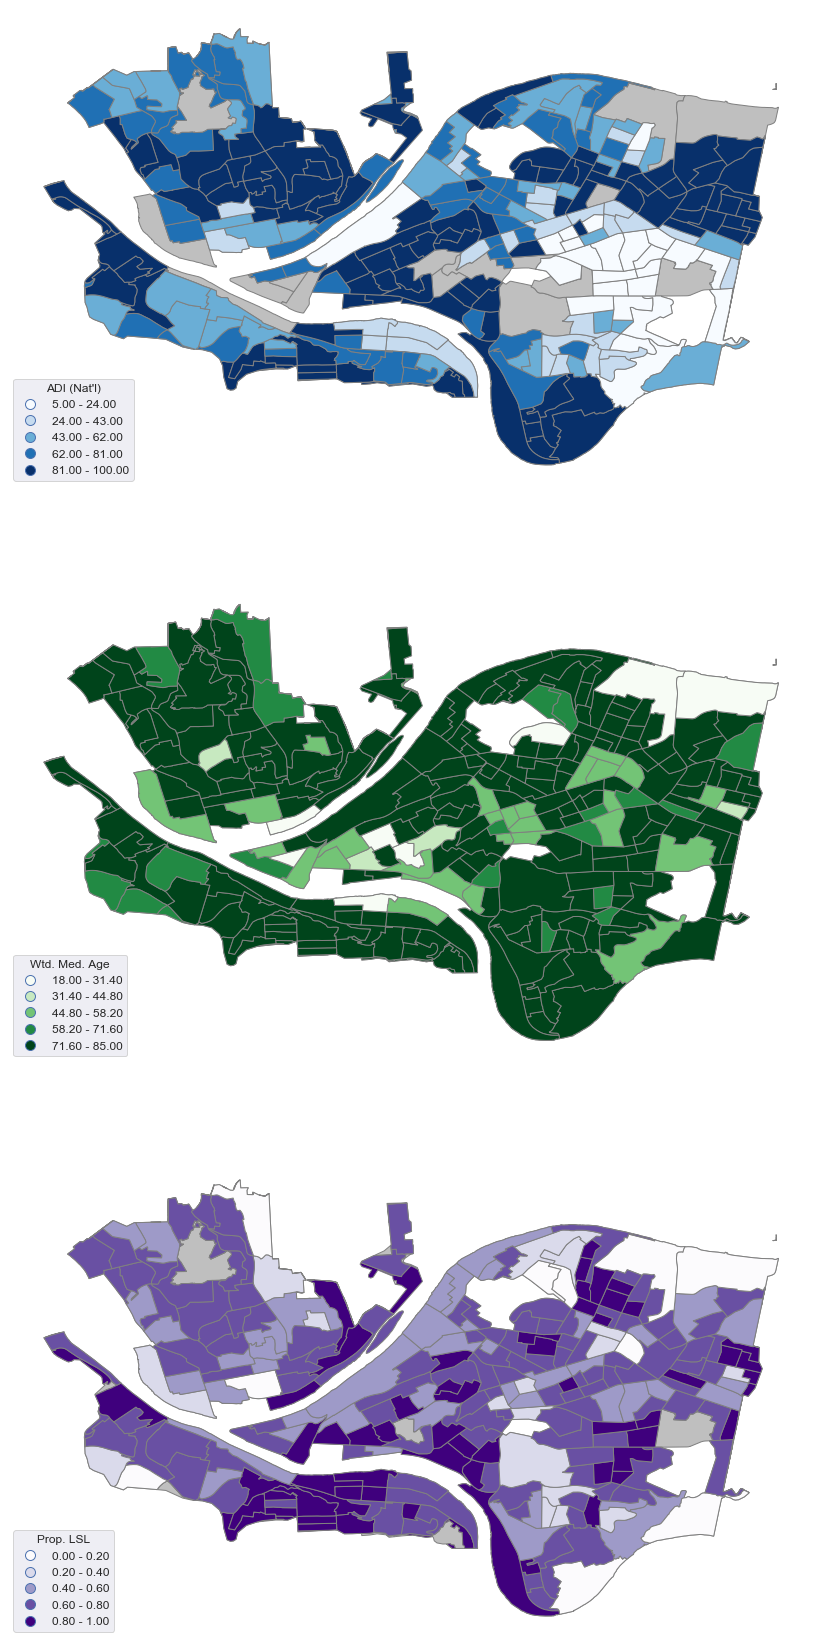

In [72]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(40, 30))
for ax in [ax1,ax2,ax3]:
    ax = gwr.plot(color='0.75',edgecolor='grey',ax=ax)
    ax.set_axis_off()
agg_df.dropna(subset=['adi_natrank']).plot(column='adi_natrank', scheme='equal_interval', cmap='Blues', linewidth=1, edgecolor='grey',legend=True,legend_kwds={'title':'ADI (Nat\'l)','loc':'lower left','title_fontsize':12,'fontsize':12}, ax=ax1)
agg_df.dropna(subset=['WMed_Age']).plot(column='WMed_Age', scheme='equal_interval', cmap='Greens', linewidth=1, edgecolor='grey',legend=True,legend_kwds={'title':'Wtd. Med. Age','loc':'lower left','title_fontsize':12,'fontsize':12}, ax=ax2)
agg_df.dropna(subset=['pct1']).plot(column='pct1', scheme='equal_interval', cmap='Purples', linewidth=1, edgecolor='grey', legend=True, legend_kwds={'title':'Prop. LSL','loc':'lower left','title_fontsize':12,'fontsize':12}, ax=ax3)

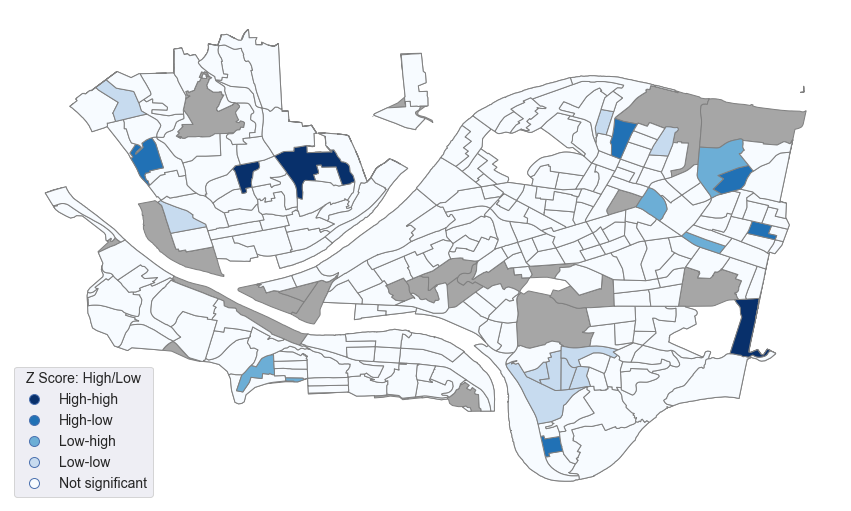

In [73]:
gwr["medianPb(Z): High/Low"] = gwr["medianPb(Z): High/Low"].astype(str).replace('nan',np.nan)
ax2 = gwr.plot(color='0.65',edgecolor='grey',figsize=(15,10))
ax2.set_axis_off()
gwr.dropna(subset=['medianPb(Z): High/Low']).plot(column='medianPb(Z): High/Low', categorical=True, 
         cmap='Blues_r', edgecolor='grey', ax=ax2, 
         legend=True, legend_kwds={'title':'Z Score: High/Low','loc':'lower left','title_fontsize':14,'fontsize':14})

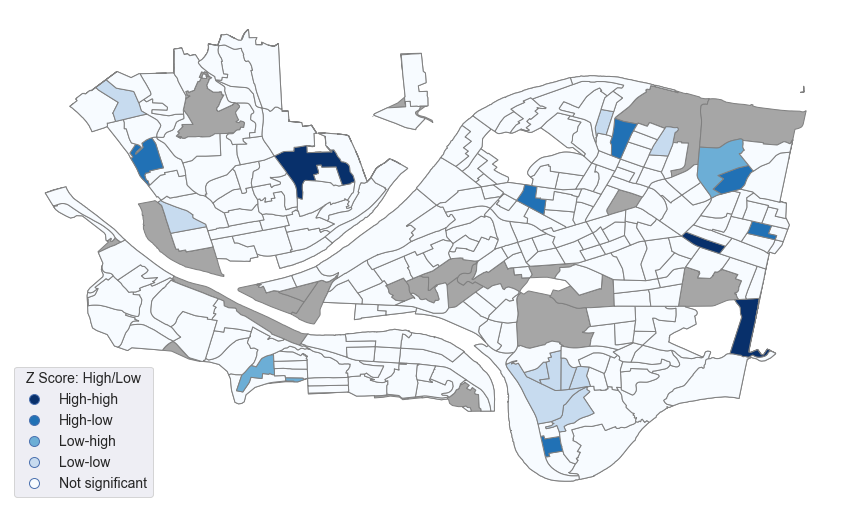

In [75]:
gwr["Residuals(Z): High/Low"] = gwr["Residuals(Z): High/Low"].astype(str).replace('nan',np.nan)
ax2 = gwr.plot(color='0.65',edgecolor='grey',figsize=(15,10))
ax2.set_axis_off()
gwr.dropna(subset=['Residuals(Z): High/Low']).plot(column='Residuals(Z): High/Low', categorical=True, 
         cmap='Blues_r', edgecolor='grey', ax=ax2, 
         legend=True, legend_kwds={'title':'Z Score: High/Low','loc':'lower left','title_fontsize':14,'fontsize':14})

       Aspatial Regression Results:                              Geographically Weighted Regression Results:

       Corr. coeff. (r):  0.055224136582468365                                Corr. coeff. (r): 0.7308608877614674


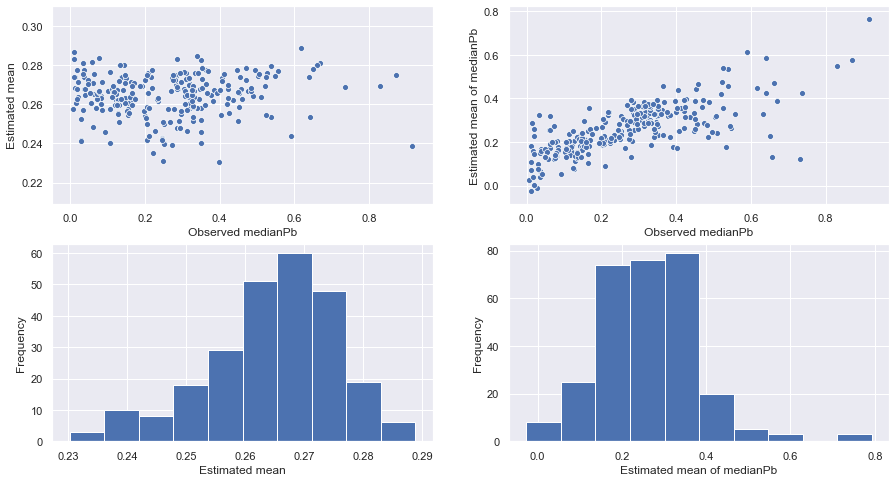

In [65]:
lr_results = pd.read_csv('Synthetic Data/aspatial_results2.csv')
gwr_results = pd.read_csv('Synthetic Data/GWR_Results-2-17-20/gwr_results.csv')

gwr['fips'], lr_results['fips'], gwr_results['fips'] = gwr['fips'].astype(str), lr_results['fips'].astype(str), gwr_results['fips'].astype(str)

gwr = pd.merge(gwr, lr_results[['fips','medianPb','medianPb(Z)','medianPb(Z): Mean neighbor value', 
                                'medianPb(Z): Ii', 'medianPb(Z): High/Low', 'medianPb(Z): P value',
                                'Residuals(Z)','Residuals(Z): Mean neighbor value', 
                                'Residuals(Z): Ii', 'Residuals(Z): High/Low', 'Residuals(Z): P value',  
                                'Estimated mean',  'Residuals','Std err of mean']],on='fips', how='left')
x = 0
cols = []
for col in gwr_results.columns:
    if x == 3:
        cols.append(col)
    else:
        if x > 8:
            cols.append(col)  
    x+=1
gwr = pd.merge(gwr, gwr_results[cols], on='fips', how='left')
gwr.drop_duplicates(subset=['fips'], inplace=True)
gwr.dropna(subset=['fips'], inplace=True)

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))
ax1 = sns.scatterplot(x="medianPb_x", y="Estimated mean", data=gwr, ax=ax1)
ax2 = sns.scatterplot(x="medianPb_x", y="Estimated mean of medianPb", data=gwr, ax=ax2)
ax1.set_xlabel('Observed medianPb')
ax2.set_xlabel('Observed medianPb')
ax3 = gwr['Estimated mean'].plot.hist(ax=ax3)
ax3.set_xlabel('Estimated mean')
ax4 = gwr['Estimated mean of medianPb'].plot.hist(ax=ax4)
ax4.set_xlabel('Estimated mean of medianPb')

c = gwr[['medianPb_x','Estimated mean','Estimated mean of medianPb']].corr()
c1, c2 = c['Estimated mean'][0], c['Estimated mean of medianPb'][0]

print('       Aspatial Regression Results:                              Geographically Weighted Regression Results:\n')
print('       Corr. coeff. (r):  {}                                Corr. coeff. (r): {}'.format(c1, c2))

In [87]:
gwr.columns[21:]

Index(['Intercept', 'ADI coeff', 'ADI coeff p value', 'ADI coeff std error',
       'r-square of ADI coeff', 'AGE coeff', 'AGE coeff p value',
       'AGE coeff std error', 'r-square of AGE coeff', 'LSL coeff',
       'LSL coeff p value', 'LSL coeff std error', 'r-square of LSL coeff',
       'Weighted mean of adi_natran', 'Weighted std dev of adi_natran',
       'Correlation b/t adi_natran and medianPb', 'Weighted mean of WMed_Age',
       'Weighted std dev of WMed_Age', 'Correlation b/t WMed_Age and medianPb',
       'Weighted mean of pct1', 'Weighted std dev of pct1',
       'Correlation b/t pct1 and medianPb', 'Weighted mean of medianPb',
       'Weighted std dev of medianPb', 'Estimated mean of medianPb',
       'Std err of mean_y', 'p-1'],
      dtype='object')

In [86]:
for col in gwr.columns:
    if 'coefficient 1' in col.lower():
        col1 = col.lower().replace('coefficient 1','ADI coeff')
    elif 'coefficient 2' in col.lower():
        col1 = col.lower().replace('coefficient 2','AGE coeff')
    elif 'coefficient 3' in col.lower():
        col1 = col.lower().replace('coefficient 3','LSL coeff')
    else:
        col1 = col
        
    gwr.rename(columns={col:col1},inplace=True)

In [94]:
pcols = []
for col in gwr.columns:
    if 'coeff p value' in col:
        pcols.append(col)

fishers = []
for i in gwr.index:
    pvalues = []
    for x in pcols:
        pvalues.append(gwr[x][i])

    PP = combine_pvalues(pvalues, method='fisher', weights=None)[1]
    fishers.append(PP)
    
gwr['Fishers P Value'] = fishers

C:\Users\raana\Anaconda3\envs\gis\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\raana\Anaconda3\envs\gis\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\raana\Anaconda3\envs\gis\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [90]:
highest = []
for i in gwr.index:
    one = abs(gwr['ADI coeff p value'][i])
    two = abs(gwr['AGE coeff p value'][i])
    three = abs(gwr['LSL coeff p value'][i])
    
    if one < two and one < three:
        highest.append('ADI')
    elif two < one and two < three:
        highest.append('AGE')
    elif three < one and three < one:
        highest.append('LSL')
    else:
        highest.append(str(min([one,two,three])))
    
gwr['p-1'] = highest

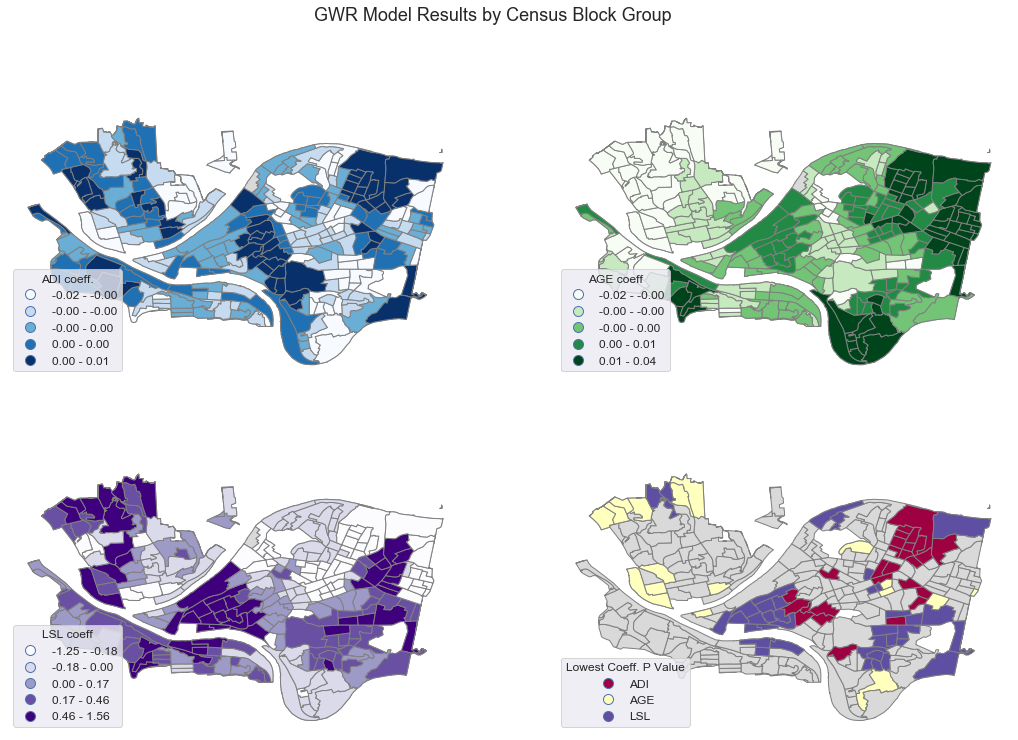

In [99]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
fig.suptitle('GWR Model Results by Census Block Group', fontsize=18)

for ax in [ax1,ax2,ax3,ax4]:
    ax = gwr.plot(color='0.85',edgecolor='grey', ax=ax)

gwr.dropna(subset=['ADI coeff']).plot(column='ADI coeff', scheme='quantiles', cmap='Blues', linewidth=1, edgecolor='grey', 
               legend=True,legend_kwds={'title':'ADI coeff.',
                                        'loc':'lower left','title_fontsize':12,'fontsize':12}, ax=ax1)
gwr.dropna(subset=['AGE coeff']).plot(column='AGE coeff', scheme='quantiles', cmap='Greens', linewidth=1, edgecolor='grey', 
               legend=True,legend_kwds={'title':'AGE coeff',
                                        'loc':'lower left','title_fontsize':12,'fontsize':12}, ax=ax2)
gwr.dropna(subset=['LSL coeff']).plot(column='LSL coeff', scheme='quantiles', cmap='Purples', linewidth=1, edgecolor='grey', 
               legend=True,legend_kwds={'title':'LSL coeff',
                                        'loc':'lower left','title_fontsize':12,'fontsize':12}, ax=ax3)

gwr[gwr['Fishers P Value']<=0.05].plot(column='p-1', cmap='Spectral', categorical=True, edgecolor='grey', ax=ax4,
                                       legend=True, legend_kwds={'title':'Lowest Coeff. P Value',
                                                                 'loc':'lower left',
                                                                 'title_fontsize':12,'fontsize':12})

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_axis_off()

In [27]:
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt
import datetime
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import shapely
from shapely import geometry
import json
import geopandas as gpd
from geopandas.tools import sjoin
import math
import scipy
from scipy.stats import rankdata, norm, combine_pvalues
from weightedstats import weighted_median

def ecdf(data, column):
    data.dropna(subset=[column], inplace=True)
    data.sort_values(column, inplace=True)
    
    n = len(data)
    y = np.arange(1, n+1) / n
    data[column+"_ecd"] = y

    return data


# Geocoding method using WRPDC geo API
def geocode(address):
    # Store address-specific links in link to run through web-scraping algorithm
    link = "https://tools.wprdc.org/geo/geocode/?addr="+address
    
    # create list of neighboring addresses
    add = address.split(" ")
    neighbors = []
    for i in range(1,51):
        neighbor = str(int(add[0])+i)
        for a in range(1,len(add)):
            neighbor = neighbor + " " + add[a]
        neighbors.append(neighbor)
        
    # Get html source from API search
    r = requests.get(link) 
    # Get full data vector from API
    soup = BeautifulSoup(r.content, "html.parser")
    
    
    # Make sure there is coordinate data
    if "ERROR" in str(soup): 
        
        # Try the neighbors:
        for i in range(0,len(neighbors)):
            link = "https://tools.wprdc.org/geo/geocode/?addr="+neighbors[i]
            r = requests.get(link)
            soup = BeautifulSoup(r.content, "html.parser")
            if "ERROR" not in str(soup):
                # Split String output by delimiters to isolate x and y coordinates
                xy = str(soup).split("[")[1].split("]")[0].split(", ")
                
                # Isolated and assign lat/long coordinates to x and y
                x, y = float(xy[0]), float(xy[1])
                result = 1
                break
            else:
                if i == len(neighbors) - 1:
                    x, y = np.nan, np.nan
                    result = 0
                else:
                    continue
        
    else: 
        # Split String output by delimiters to isolate x and y coordinates
        xy = str(soup).split("[")[1].split("]")[0].split(", ")
        x, y = float(xy[0]), float(xy[1])
        result = 1

        
    xy = tuple([x,y])
    
    return xy, result